---
title: Pytorch入门实战：使用 Char-RNN 对名字进行分类  
date: 2018-09-13 01:46:14    
updated: 2018-09-13 01:46:14    
tags:   
mathjax: true  
categories: ['深度学习', 'Pytorch与Mxnet']  

---

本文参考 pytorch 官网 tutorial，这次的任务是训练一个可以对名字进行国籍分类的网络。如：
> zhang chinese  
> Bob   english

在官方教程的基础上，我实现了原始的 `RnnOrign`、`GRU` 与 `LSTM`。（这个 tutorial 上的模型与原始的 rnn 不一样）。但感觉这种单个字符使用 `GRU` 和 `LSTM` 的效果不是很好。

# 准备数据
Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

- `unicodeToAscii`： `Unicode` 转为 `Ascii`。例如 `Čech` 转为 `Cech`。

- `readLines`： 返回一个list，list中每一项代表文件中的一行，已经经过转码。

- `category_lines`： `{'chinese':[...], 'Italian':[...], ...}`

- `all_categories`: `['chinese', 'Italian', ...]`

In [1]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('./data/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['./data/data/names/Chinese.txt', './data/data/names/Italian.txt', './data/data/names/Scottish.txt', './data/data/names/Dutch.txt', './data/data/names/Spanish.txt', './data/data/names/English.txt', './data/data/names/Vietnamese.txt', './data/data/names/German.txt', './data/data/names/Irish.txt', './data/data/names/Korean.txt', './data/data/names/Czech.txt', './data/data/names/Russian.txt', './data/data/names/Polish.txt', './data/data/names/Greek.txt', './data/data/names/French.txt', './data/data/names/Japanese.txt', './data/data/names/Arabic.txt', './data/data/names/Portuguese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# 将名字转为Tensor

- `letterToIndex`： 返回字符在所有 ascii 对应的 索引

- `letterToTensor`： 返回字符 one-hot 编码，shape = (1, n_letters)

- `lineToTensor`： 返回单词的 one-hot 编码， shape = (len(word), n_letters)

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# 创建网络
原文中的网络和一般的 rnn 网络不一样，计算流图长这样
![image](/images/char_rnn_classification.png)

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

我再建立一个原始的 RNN、GRU，最后分别比较它们的性能，原始的 RNN 网络长这样：
![image](/images/rnn.svg)

In [5]:
class RnnOrign(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

建立一个GRU。

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.reset_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid()
        )
        self.update_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid()
        )
        
        self.to_candidata = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )
        
        self.to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_data, hidden):
        combined_ih = torch.cat((input_data, hidden), dim=1)
        reset = self.reset_gate(combined_ih)
        update = self.update_gate(combined_ih)
        combined_ir = torch.cat((input_data, torch.mul(reset, hidden)), dim=1)
        candidate = self.to_candidata(combined_ir)
        hidden = torch.mul(update, hidden) + torch.mul((1 - update), candidate)
        output = self.to_output(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

建立一个LSTM。

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.input_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid()
        )
        
        self.forget_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid()
        )
        
        self.output_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid()
        )
        
        self.to_candidate_cell = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )
        
        self.to_output = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, input_data, hidden, cell):
        combined_ih = torch.cat((input_data, hidden), dim=1)
        
        # 得到三个门
        input_gate = self.input_gate(combined_ih)
        forget_gate = self.forget_gate(combined_ih)
        output_gate = self.output_gate(combined_ih)
        
        # 得到候选记忆细胞
        candidate_cell = self.to_candidate_cell(combined_ih)
        
        # 得到真正的记忆细胞
        cell = torch.mul(forget_gate, cell) + torch.mul(input_gate, candidate_cell)
        
        # 得到隐藏状态
        hidden = torch.mul(output_gate, cell)
        
        # 得到输出
        output = self.to_output(hidden)
        output = self.softmax(output)
        
        return output, hidden, cell
        
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

实例化网络

In [8]:
n_hidden = 128
rnn = GRU(n_letters, n_hidden, n_categories)

看看网络的输入输出是怎样的，先输入一个字母试试

In [9]:
input_letter = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_letter, hidden)
print('output: {output}'.format(output=output))
print('hidden shape: {0}'.format(next_hidden.shape))

output: tensor([[-2.9183, -2.9258, -2.8348, -2.8959, -2.9211, -2.8425, -2.8438, -2.9436,
         -2.9522, -2.8383, -2.9769, -2.8509, -2.9041, -2.8288, -2.7987, -2.8841,
         -2.9880, -2.9045]], grad_fn=<LogSoftmaxBackward>)
hidden shape: torch.Size([1, 128])


为了高效，我们会使用 `lineToTensor`

In [10]:
input_word = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_word[0], hidden)
print(output.shape)

torch.Size([1, 18])


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




# 训练

## 训练准备

rnn最后的输出是每种可能性的对数概率，我们需要一个函数，将对数概率转为相应的国家。

In [11]:
def categoryFromOutput(output):
    _, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 14)


我们也需要一个便捷的函数，来得到训练样本

In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '\t', 'line =', line)

category = Dutch 	 line = Pey
category = Vietnamese 	 line = Ly
category = Korean 	 line = San
category = Czech 	 line = StrakaO
category = Irish 	 line = O'Boyle


## 训练网络

因为之前我们使用了 `nn.LogSoftmax` 作为输出，所以我们的 criterion 使用 `nn.NLLLoss`

$$
\text{loss}(\mathbf{X}, \text{label}) = - \mathbf{X}_{\text{label}}
$$

In [13]:
criterion = nn.NLLLoss()

每一轮训练我们将做下面的事情：
1. 创建输入和目标张量
2. 创建初始化为0的隐藏状态
3. 前行传播每个字母的张量，输出 output 和 hidden
4. 将最终输出与目标进行比较，求 loss
5. 反向传播
6. 返回输出和损失


In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(model, category_tensor, line_tensor):
    hidden = model.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

现在开始运行

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



def TrainIteration(model):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    start = time.time()
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(model, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses
            
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
rnn = RNN(n_letters, n_hidden, n_categories)
all_losses = TrainIteration(rnn)

5000 5% (0m 3s) 2.6303 Carmichael / Russian ✗ (English)
10000 10% (0m 7s) 2.1603 Vicario / Portuguese ✗ (Spanish)
15000 15% (0m 11s) 2.0848 Freitas / Greek ✗ (Portuguese)
20000 20% (0m 15s) 2.1980 Dupond / English ✗ (French)
25000 25% (0m 19s) 0.6740 Toloni / Italian ✓
30000 30% (0m 23s) 1.2535 Pho / Korean ✗ (Vietnamese)
35000 35% (0m 26s) 1.6050 Plisek / Polish ✗ (Czech)
40000 40% (0m 29s) 0.0950 Filipowski / Polish ✓
45000 45% (0m 32s) 6.6516 Gravari / Italian ✗ (Greek)
50000 50% (0m 35s) 0.0115 Akrivopoulos / Greek ✓
55000 55% (0m 40s) 0.7157 Medeiros / Portuguese ✓
60000 60% (0m 45s) 0.3900 De santigo / Portuguese ✓
65000 65% (0m 49s) 1.1226 Travieso / Spanish ✓
70000 70% (0m 53s) 4.5673 Ville / English ✗ (Russian)
75000 75% (0m 57s) 1.1974 Hang / Korean ✗ (Chinese)
80000 80% (1m 1s) 1.7593 Rose / French ✓
85000 85% (1m 4s) 0.6080 Lecuyer / French ✓
90000 90% (1m 9s) 1.4378 Belanger / German ✗ (French)
95000 95% (1m 12s) 0.2523 Wawrzaszek / Polish ✓
100000 100% (1m 15s) 1.0511 Pel

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




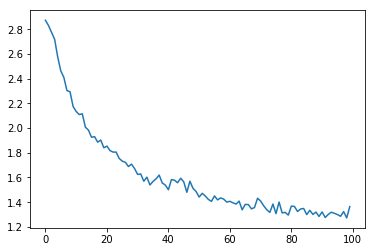

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 评估结果

为了知道网络在不同类别上的表现如何，我们将创建一个混淆矩阵，表示实际语言（行）网络猜测的语言（列）。

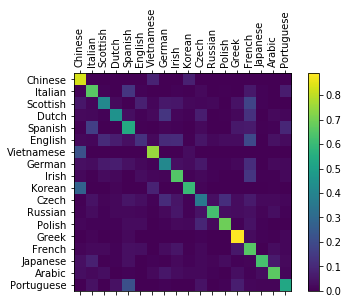

In [17]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

我们也可以运行我们自己的输入

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Han')
predict('Peng')
predict('Jin')


> Han
(-0.31) Chinese
(-2.01) Vietnamese
(-2.77) Korean

> Peng
(-0.19) Chinese
(-3.24) Dutch
(-3.68) German

> Jin
(-0.29) Chinese
(-2.17) Korean
(-3.66) English
